# Résolution du modèle proie-prédateur dérivé de l'équation d'agrégation

Il s'agit de résoudre un problème similaire à l'équation d'agrégation, sauf qu'ici on prend en compte le couplage entre deux groupes d'individus (des proies et des prédateurs). Le but est alors de résoudre le problème suivant :

$$
\begin{cases}
\partial_t\rho_1 + \partial_x (\rho_1(W_1' * \rho_1+K'*\rho_2)) &= 0, \\
\partial_t\rho_2 + \partial_x (\rho_2(W_2' * \rho_2-\beta K'*\rho_1)) &= 0, \\
\rho_1(0,.) &= \rho_1^{\text{ini}}, \\
\rho_2(0,.) &= \rho_2^{\text{ini}}, \\
\end{cases}
$$

où $\rho_1$ et $\rho_2$ sont des mesures de probabilité paramétrées par le temps. Pour résoudre ce problème, on va utiliser le schéma présenté plus en détail dans [[1]](https://arxiv.org/pdf/1912.06423.pdf) et [[2]](https://arxiv.org/pdf/1602.05746.pdf).

Pour rappel, il prend la forme suivante :

$$ \begin{cases}
\rho_{1i}^{n+1}=\rho_{1i}^{n}-\frac{\Delta_t}{\Delta_x}(\mathcal{F}_{1~i+1/2}^n-\mathcal{F}_{1~i-1/2}^n), \\
\rho_{2i}^{n+1}=\rho_{2i}^{n}-\frac{\Delta_t}{\Delta_x}(\mathcal{F}_{2~i+1/2}^n-\mathcal{F}_{2~i-1/2}^n). \\
\end{cases}$$

Les flux numériques utilisés sont :
$$\begin{cases}
\mathcal{F}_{1~i+1/2}=(a_{1i}^n)^+\rho_{1i}^n-(a_{1i+1}^n)^-\rho_{1i+1}^n, \\ 
\mathcal{F}_{2~i+1/2}=(a_{2i}^n)^+\rho_{2i}^n-(a_{2i+1}^n)^-\rho_{2i+1}^n, \\
\end{cases}$$
avec 
$$\begin{cases} a_{1i}^n=-\sum_{l}(\rho_{1l}^n W_1'(x_i-x_l)+\rho_{2l}^n K'(x_i-x_l)),\\
a_{2i}^n=-\sum_{l}(\rho_{2l}^n W_2'(x_i-x_l)-\beta\rho_{1l}^n K'(x_i-x_l)).\\
\end{cases}$$

## Sommaire :
* [Paramètres/fonctions du problème](#t1)
* [Implémentation du schéma](#t2)

In [1]:
# Importations :
import numpy as np
import matplotlib.pyplot as plt
import os

### Définition des paramètres et fonctions du problème <a class="anchor" id="t1"></a>

In [2]:
# Potentiel d'interaction W1 et sa dérivée :
W1   = lambda x : np.abs(x)  # Potentiel d'interaction
dxW1 = lambda x : np.sign(x) # Dérivée de W1

# Potentiel d'interaction W2 et sa dérivée :
W2   = lambda x : np.abs(x)  # Potentiel d'interaction
dxW2 = lambda x : np.sign(x) # Dérivée de W2

# Potentiel d'interaction K et sa dérivée :
K   = lambda x : np.abs(x)  # Potentiel d'interaction
dxK = lambda x : np.sign(x) # Dérivée de K

# Fonctions pour initialiser la solution :
rho1_ini = lambda x : 1.*(x>-0.99)*(x<-0.98)
rho2_ini = lambda x : 1.*(x>-0.05)*(x<0.05)

# Définition de la grille spatiale :
xmin = -1  # Borne de gauche du domaine
xmax = 1   # Borne de droite du domaine
Nx   = 256 # Nombre de points de la discrétisation en espace
grid = np.linspace(xmin, xmax, Nx) # Grille
Dx   = grid[1]-grid[0] # Pas d'espace

# Discrétisation en temps :
Nt = 1000 # Nombre de points de la discrétisation en temps
tf = 2    # Temps final
T = np.linspace(0, tf, Nt) # Temps discrets
Dt = T[1]-T[0] # Pas de temps

beta = .3 # Vitesse des proies

### Implémentation du schéma <a class="anchor" id="t2"></a>

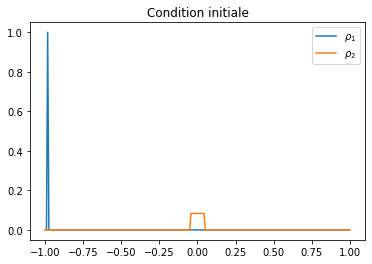

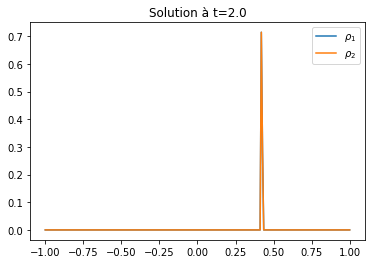

In [3]:
# Création du fichier pour la sauvegarde des figures :
if not os.path.exists('./figures4'):
    os.makedirs('./figures4')

# Matrices pour contenir les potentiels :
W1p = dxW1(np.tile(grid.reshape((Nx, 1)), (1, Nx)) - grid)
W2p = dxW2(np.tile(grid.reshape((Nx, 1)), (1, Nx)) - grid)
Kp  = dxK(np.tile(grid.reshape((Nx, 1)), (1, Nx)) - grid)

# Initialisation rho1 :
rho1  = rho1_ini(grid)
s1    = sum(rho1)
rho1 /= s1 # Normalisation

# Initialisation rho2 :
rho2  = rho2_ini(grid)
s2    = sum(rho2)
rho2 /= s2 # Normalisation

# Plot de la condition initiale :
plt.plot(grid, rho1, label=r"$\rho_1$")
plt.plot(grid, rho2, label=r"$\rho_2$")
plt.legend()
plt.title("Condition initiale")
plt.show()

# Contrôle des intégrales :
#print("Masse totale initiale rho_1 :", sum(rho1))
#print("Masse totale initiale rho_2 :", sum(rho2))

# Variables pour vitesses macroscopiques & variables intermédiaires :

a1 = np.zeros(Nx) # Pour la vitesse macroscopique a1
rho1_dp = np.zeros(Nx) # Pour contenir un vecteur "avec décalage"
rho1_gm = np.zeros(Nx) # Pour contenir un vecteur "avec décalage"

a2 = np.zeros(Nx) # Pour la vitesse macroscopique a2
rho2_dp = np.zeros(Nx) # Pour contenir un vecteur "avec décalage"
rho2_gm = np.zeros(Nx) # Pour contenir un vecteur "avec décalage"

# Boucle de résolution :
cpt = 0 # Nombre de sauvegardes
for n,t in enumerate(T):

    # Calcul de la vitesse macroscopique a1 :
    a1 = - (np.dot(W1p, rho1) + np.dot(Kp, rho2))
    
    # Calcul de la vitesse macroscopique a1 :
    a2 = - (np.dot(W2p, rho2) - beta * np.dot(Kp, rho1))
    
    # Mise à jour de rho1 :
    a1p = a1*(a1>=0)  # Partie positive de a1
    a1m = -a1*(a1<=0) # Partie négative de a1
    rho1_dp[1:]  = a1p[:-1]*rho1[:-1]
    rho1_gm[:-1] = a1m[1:]*rho1[1:]
    rho1 -= Dt/Dx*(a1p*rho1+a1m*rho1-rho1_dp-rho1_gm)
    
    # Mise à jour de rho2 :
    a2p = a2*(a2>=0)  # Partie positive de a2
    a2m = -a2*(a2<=0) # Partie négative de a2
    rho2_dp[1:]  = a2p[:-1]*rho2[:-1]
    rho2_gm[:-1] = a2m[1:]*rho2[1:]
    rho2 -= Dt/Dx*(a2p*rho2+a2m*rho2-rho2_dp-rho2_gm)
    
    # Pour un affichage de la solution à intervalles réguliers :
    if (not n%10):
        cpt += 1
        plt.plot(grid, rho1, label=r"prédateurs $\rho_1$")
        plt.plot(grid, rho2, label=r"proies $\rho_2$")
        plt.ylim([0, 1.1])
        plt.title("t = "+str(round(t,2)))
        plt.legend()
        plt.savefig("./figures4/etape"+str(cpt)+".pdf", facecolor='white', transparent=False)
        plt.clf()
        # plt.show()
        # Contrôle des intégrales :
        #print("Masse totale initiale rho_1 :", sum(rho1))
        #print("Masse totale initiale rho_2 :", sum(rho2))
        
# Plot de la condition initiale :
plt.plot(grid, rho1, label=r"$\rho_1$")
plt.plot(grid, rho2, label=r"$\rho_2$")
plt.legend()
plt.title("Solution à t="+str(round(t, 2)))
plt.show()

**Remarques :** 
- Pour vérifier que le schéma est conservatif, il est équivalent de contrôler la masse _Dx * s1 * sum(rho1)_ ou simplement _sum(rho1)_ ; c'est la même chose à un facteur près.
- Dans le notebook sur l'équation d'agrégation, on constatait qu'une masse de Dirac correspondait à la concentration de toute la masse dans deux cellules, si bien qu'on ne dépassait jamais 0.5 pour la hauteur de la solution normalisée. Ici on constate qu'on peut monter jusqu'à 1. Alors soit l'un des codes comporte une erreur, soit une masse de Dirac peut être concentrée par le schéma dans une ou deux cellules selon les cas.